## Challenge 2 (2 points) -- Rookie

Signal in colored, Gaussian noise.

* Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
* The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)

2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt".
   with the same parameters as above.  Plot this waveform.

3. Calculate a PSD of the data, and plot this on a log-log scale.
   Use axes ranging from 20 Hz up to the Nyquist frequency.

4. Use the template waveform and PSD to calculate the SNR time series.  Plot the SNR time-series.

5. What is the matched filter SNR of the signal?

In [12]:
# -- download data
# ! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

--2023-05-24 06:50:46--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gwosc.org/s/workshop3/challenge/challenge2.gwf [following]
--2023-05-24 06:50:47--  https://gwosc.org/s/workshop3/challenge/challenge2.gwf
Resolving gwosc.org (gwosc.org)... 131.215.113.73
Connecting to gwosc.org (gwosc.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf.4’

challenge2.gwf.4    100%[===================>]   3.84M   791KB/s    in 5.0s    

2023-05-24 06:50:53 (791 KB/s) - ‘challenge2.gwf.4’ saved [4025842/4025842]



In [2]:
from pycbc import frame

strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
print(strain.sample_rate, strain.duration, strain.start_time)

4096.0 128.0 -64


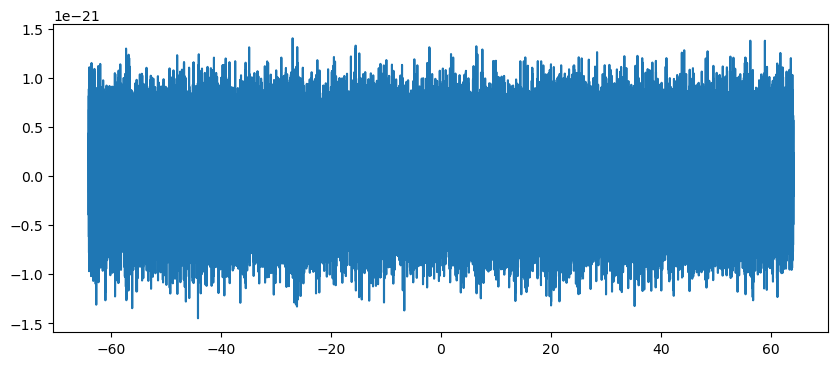

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 4]

# strain.start_time = 0
plt.plot(strain.sample_times, strain)

In [4]:
strain.delta_t, strain.delta_f

(0.000244140625, 0.0078125)

In [5]:
# t, f, p = strain.qtransform(0.001, frange=[20, 512])
# plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
# plt.yscale('log')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.xlim(-20, 0)
# plt.show()

Approximate time of the merger : -15.0 s

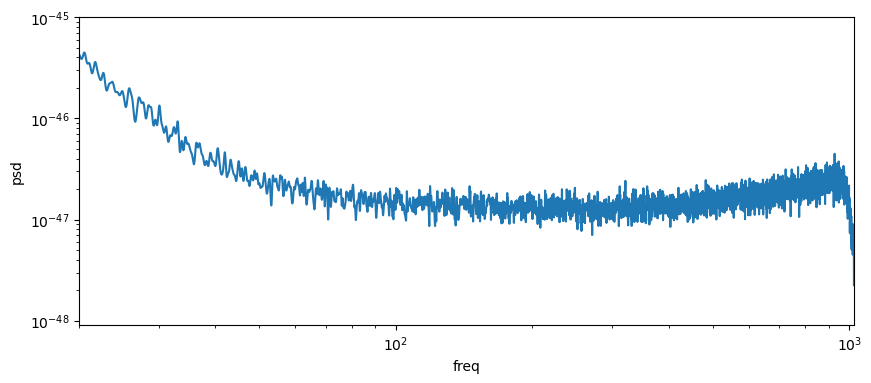

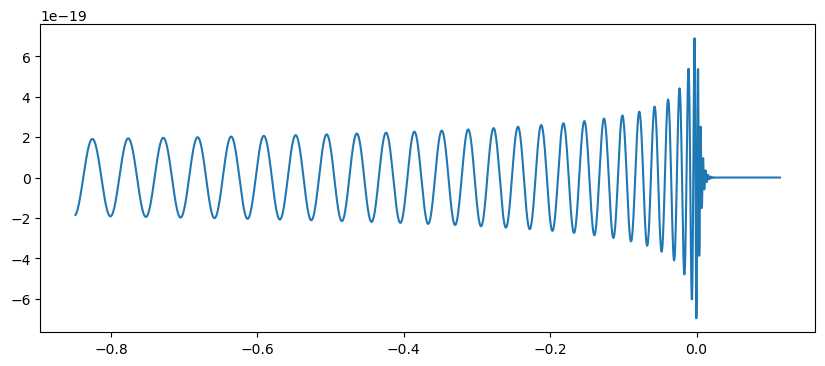

Mass: 30. We found a signal at -14.6328125s with SNR 22.053006342518433
The time of peak is (considering start time of the signal) : 49.3671875


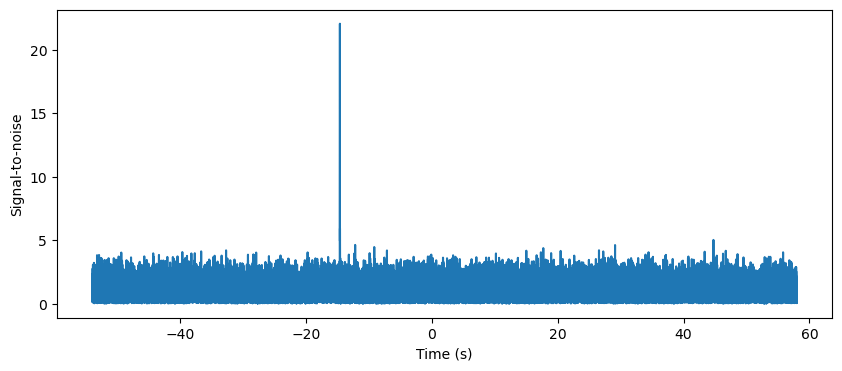

In [11]:
from pycbc.filter import matched_filter, highpass, resample_to_delta_t
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation

# template masses
mass = [30] # Solar masses
spin = 0

# #TODO: Read data
ts = strain
# Remove the low frequency content and downsample the data to 2048Hz,
# also, cropped the numerical artifact
ts = highpass(ts, 15.0)
ts = resample_to_delta_t(ts, 1.0/2048)
ts = ts.crop(2,2)

#TODO: Estimate the power spectral density
# We use 4 second samples of our time series in Welch method.
psd = ts.psd(4)
psd = interpolate(psd, ts.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * ts.sample_rate),
                                low_frequency_cutoff=15)
plt.loglog(psd.sample_frequencies, psd)
plt.xlim(20, ts.sample_rate/2)
plt.ylim(top=1e-45)
plt.xlabel("freq")
plt.ylabel("psd")
plt.show()

#TODO: template generation and match filtering
for m in mass:
    hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                        mass1=m,
                        mass2=m,
                        spin=spin,
                        delta_t=ts.delta_t,
                        f_lower=20)
    plt.plot(hp.sample_times, hp)
    plt.show()
    # Resize the vector to match our data
    hp.resize(len(ts))
    hp = hp.cyclic_time_shift(hp.start_time)

    # match filtering
    snr = matched_filter(hp, ts,
                        psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4 + 4, 4)

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]

    print("Mass: {}. We found a signal at {}s with SNR {}".format(m, + time, abs(snrp)))
    print("The time of peak is (considering start time of the signal) : {}".format(-strain.start_time + time))
    # did not use ts, since ts was cropped 2sec at the beginning, thus the start_time got +2
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('Signal-to-noise')
    plt.xlabel('Time (s)')
    plt.show()

Not downsampled --  
Mass: 30. We found a signal at -14.6328125s with SNR 22.08430205551194  
The time of peak is (considering start time of the signal) : 49.3671875

Downsampled to 2048Hz --  
Mass: 30. We found a signal at -14.6328125s with SNR 22.053006342518433  
The time of peak is (considering start time of the signal) : 49.3671875